In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Helper functions for preprocessing, inspecting, and visualising data

In [2]:
def calculate_portion_of_columns_with_nans(dataframe: pd.DataFrame) -> float:
    """Computes the portion of columns with nan values

    Args:
        dataframe: A pandas dataframe

    Returns:
        The portion of columns with nan values
    """
    missing_values = dataframe.isna().sum().sort_values(ascending=False)/dataframe.shape[0]
    missing_values_df = missing_values.to_frame(name='portion')
    num_columns_with_missing_values = missing_values_df[missing_values_df['portion'] > 0].shape[0]
    portion = num_columns_with_missing_values/dataframe.shape[1]
    return portion


In [3]:
def cleanup_price(price: str) -> float:
    """Cleans up price by converting to float and removign $ sign

    Args:
        price: price of the listing
    
    Returns:
        price as a float    
    """
    if type(price) != float:
        return float(price[1:].replace(",",""))  
    else:
        return price

### The Seatle Airbnb Open Data

Read the data

In [4]:
airbnb_calendar = pd.read_csv("./data/calendar.csv")
airbnb_listings = pd.read_csv("./data/listings.csv")
airbnb_review = pd.read_csv("./data/reviews.csv")

datasets = {"airbnb_calendar": airbnb_calendar, "airbnb_listings": airbnb_listings, "airbnb_review": airbnb_review}

Inspect the number of rows and columns in each dataset

In [5]:
for dataset_name, dataset in datasets.items():
    print(f"{dataset_name} has {dataset.shape[0]} rows and {dataset.shape[1]} columns")

airbnb_calendar has 1393570 rows and 4 columns
airbnb_listings has 3818 rows and 92 columns
airbnb_review has 84849 rows and 6 columns


We will check the portion of columns that have 'nan' values. 

In [6]:
for dataset_name, dataset in datasets.items():
    print(f"Portion of columns with NaN in {dataset_name} is {calculate_portion_of_columns_with_nans(dataset)}")

Portion of columns with NaN in airbnb_calendar is 0.25
Portion of columns with NaN in airbnb_listings is 0.5
Portion of columns with NaN in airbnb_review is 0.16666666666666666


We can see that 25 % of the columns in the calendar dataset have missing values, and 50 % of the columns in the listing dataset.

Let's focus on the listing dataset and can drop the columns that have missing data. We can focus on the columns that contain data. Depending on the buisness question we may have to keep the the columns we are dropping. In this case let's assume they are not important for our buisness question.

In [7]:
listings_missing_values = airbnb_listings.isna().sum().sort_values(ascending=False)/airbnb_listings.shape[0]
listings_missing_values_df = listings_missing_values.to_frame(name='portion')
list_of_listing_columns_drop = listings_missing_values_df[listings_missing_values_df['portion'] > 0].index.to_list()
airbnb_listings.drop(columns=list_of_listing_columns_drop, axis=1, inplace=True)

In [8]:
airbnb_listings.head()

,id,listing_url,scrape_id,last_scraped,name,description,experiences_offered,picture_url,host_id,host_url,...,availability_365,calendar_last_scraped,number_of_reviews,requires_license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,Make your self at home in this charming one-be...,none,https://a1.muscache.com/ac/pictures/67560560/c...,956883,https://www.airbnb.com/users/show/956883,...,346,2016-01-04,207,f,WASHINGTON,f,moderate,f,f,2
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,none,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,...,291,2016-01-04,43,f,WASHINGTON,f,strict,t,t,6
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,none,https://a2.muscache.com/ac/pictures/b4324e0f-a...,16708587,https://www.airbnb.com/users/show/16708587,...,220,2016-01-04,20,f,WASHINGTON,f,strict,f,f,2
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,none,https://a0.muscache.com/ac/pictures/94146944/6...,9851441,https://www.airbnb.com/users/show/9851441,...,143,2016-01-04,0,f,WASHINGTON,f,flexible,f,f,1
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,none,https://a1.muscache.com/ac/pictures/6120468/b0...,1452570,https://www.airbnb.com/users/show/1452570,...,365,2016-01-04,38,f,WASHINGTON,f,strict,f,f,1


The price is in Dollars and is a string, however we want to treat the price numerically so we'll drop the '$' and convert to a float.

In [9]:
airbnb_listings['price'] = airbnb_listings['price'].apply(cleanup_price)

Now we've cleaned up the price, let's answer the following question:

### Q1) Which neighbourhoods have the highest price in Seattle?

In [10]:
neighbourhood_mean_prices = {}
for neighbourhood in airbnb_listings['neighbourhood_group_cleansed'].unique():
    neighbourhood_mean_prices[neighbourhood] = airbnb_listings[airbnb_listings['neighbourhood_group_cleansed'] == neighbourhood]['price'].mean()

In [11]:
sorted_mean_prices = dict(sorted(neighbourhood_mean_prices.items(), key=lambda x:x[1])).keys()

Text(0.5, 1.0, 'Listing price distribution for neighbourhoods in Seattle')

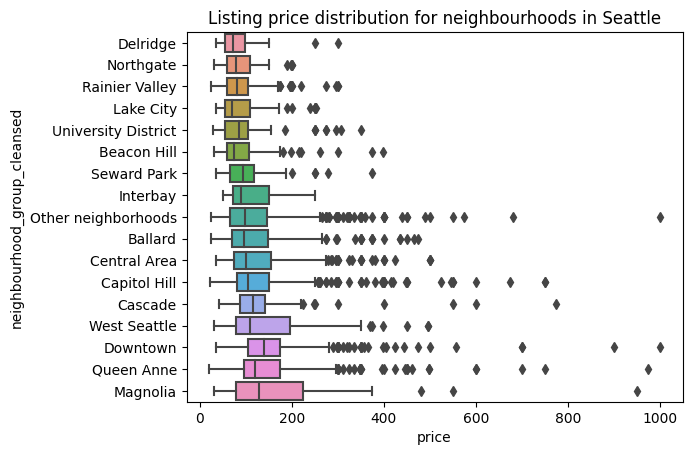

In [12]:
sns.boxplot(data=airbnb_listings, x='price', y='neighbourhood_group_cleansed', order=sorted_mean_prices)

plt.title('Listing price distribution for neighbourhoods in Seattle')

From the boxplot we can see that on average Magnolia has the highest priced listings whereas Delridge has the lowest priced listings. We can also see that Magonlia has the highest variation in prices across the listings. We've chosen a boxplot for showing the data so we can get a broader understadnding of the data. We could have jsut extracted the highest mean value, however this would not give us information about the variability in the data.

### Question 2:
Does the number of ammenities offered correlate with the price of the listing? and does the Magnolia neighbourhood offer more ammenities?

Firstly, the ammenities is a string. We want the set of ammenities, so first we will process the sring and clean up the data. We can see the amenities column is a python set that has been saved as a string, so lets proces the string and convert it back to a set

In [13]:
airbnb_listings['num_amenities'] = airbnb_listings['amenities'].apply(lambda amenities: len(set(amenities[1:-1])))

Text(0.5, 1.0, 'Number of amenities and price correlation')

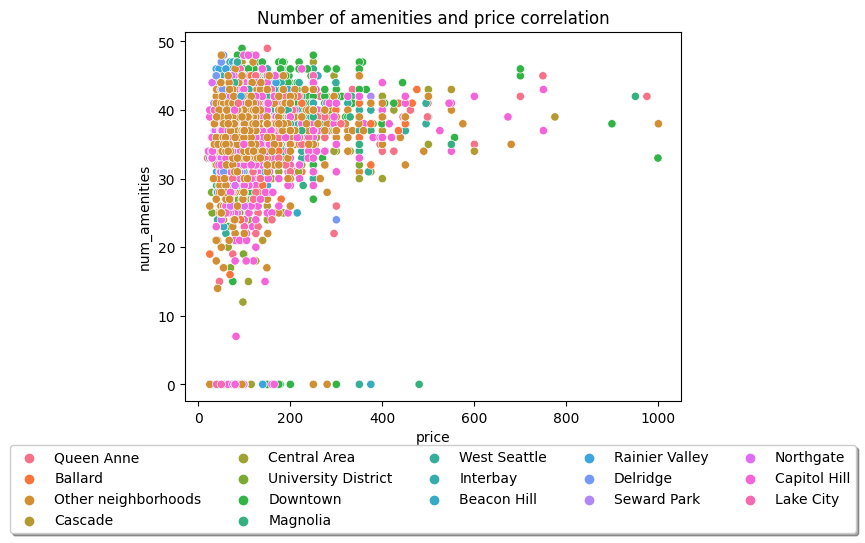

In [14]:
sns.scatterplot(data=airbnb_listings, x='price', y='num_amenities', hue='neighbourhood_group_cleansed')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),fancybox=True, shadow=True, ncol=5)
plt.title('Number of amenities and price correlation')

It doesn't look like there is a correlation between the price and the number of amenities. That's great news for AirBnB customers as they have alot of choice at lower proce points that contain a large number of amenities. AirBnB hosts don't have to worry about adding more amenities to get higher price points. The investment into more amenities may not pay off, and there are cheaper apartments available.

# Question 3:
In which month are the listings in the magnolia neighbourhood priced the highest?

In [15]:
# Get all the magnolia listings
magnolia_listings = airbnb_listings[airbnb_listings["neighbourhood_group_cleansed"] == "Magnolia"]

In [16]:
# Get all the Magnolia listings from the calendar file
in_magnolia = airbnb_calendar["listing_id"].isin(magnolia_listings.id.values)
airbnb_calendar["in_magnolia"] = in_magnolia
magnolia_airbnb_calendar = airbnb_calendar[airbnb_calendar["in_magnolia"] == True].copy()

In [17]:
# Remove cases where price is 'NaN' as the listing is not available
magnolia_airbnb_calendar.dropna(subset=['price'], axis=0, inplace=True)

In [18]:
magnolia_airbnb_calendar['date'] = magnolia_airbnb_calendar['date'].apply(lambda x: '-'.join(x.split('-')[:-1]))

In [19]:
magnolia_airbnb_calendar['price'] = magnolia_airbnb_calendar['price'].apply(cleanup_price)

In [20]:
figure_date_order = sorted(set(magnolia_airbnb_calendar['date'].values))

Text(0.5, 1.0, 'Listing prices in Magnolia across time')

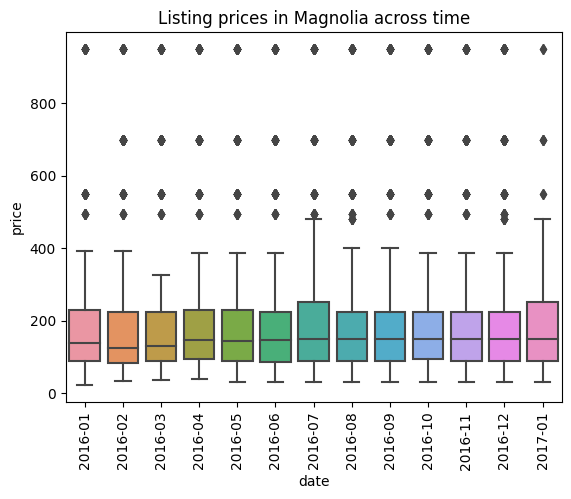

In [21]:
sns.boxplot(data=magnolia_airbnb_calendar, x='date', y='price', order=figure_date_order)
plt.xticks(rotation=90)
plt.title('Listing prices in Magnolia across time')

We see there is not much seasonal fluctuation. The mean price is almost constant and there appears to be a slight spike in price in July 2016 and January 2017.